# 0- Business Problem

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied

For each id in the test set, you must predict the probability of target (likelihood of the presence of a kidney stone). The file should contain a header and have the following format:

This dataset can be used to predict the presence of kidney stones based on urine analysis.

The 79 urine specimens, were analyzed in an effort to
determine if certain physical characteristics of the urine might be related to the
formation of calcium oxalate crystals.
The six physical characteristics of the urine are: 
(1) specific gravity, the density of the urine relative to water; 
(2) pH, the negative logarithm of the hydrogen ion; 
(3) osmolarity (mOsm), a unit used in biology and medicine but not in
physical chemistry. Osmolarity is proportional to the concentration of
molecules in solution; 
(4) conductivity (mMho milliMho). One Mho is one
reciprocal Ohm. Conductivity is proportional to the concentration of charged
ions in solution; 
(5) urea concentration in millimoles per litre; and 
(6) calcium
concentration (CALC) in millimolesllitre.

The data is obtained from 'Physical Characteristics of Urines With and Without Crystals',a chapter from Springer Series in Statistics.

https://link.springer.com/chapter/10.1007/978-1-4612-5098-2_45

# 1 - Import Packages

In [32]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew,kurtosis
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


## 1.1 Functions

# 2 - Load Data

In [2]:
raw_test = pd.read_csv("../data/test.csv")
raw_train = pd.read_csv("../data/train.csv")

In [3]:
print(f"Train sahpe = {raw_train.shape}   Test shape = {raw_test.shape}")

Train sahpe = (414, 8)   Test shape = (276, 7)


In [4]:
raw_train.columns

Index(['id', 'gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target'], dtype='object')

In [5]:
raw_train.dtypes

id           int64
gravity    float64
ph         float64
osmo         int64
cond       float64
urea         int64
calc       float64
target       int64
dtype: object

In [6]:
raw_train.head(5)

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [7]:
raw_train.describe()

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,119.655756,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,103.250000,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,206.500000,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,309.750000,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
max,413.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


# 3 - Descriptive Analysis

In [8]:
df3 = raw_train

In [9]:
df3["target"].value_counts()*100/len(df3)

0    55.555556
1    44.444444
Name: target, dtype: float64

In [10]:
pd.DataFrame({"columns" : df3.columns,"skew": skew(df3),"kurtosis" : kurtosis(df3)})

,columns,skew,kurtosis
0,id,0.000000,-1.200014
1,gravity,0.289954,-0.019158
2,ph,0.967785,0.595484
3,osmo,0.146861,-0.496470
4,cond,-0.211240,-0.680120
5,urea,0.327913,-0.573939
6,calc,1.114477,0.640783
7,target,0.223607,-1.950000


In [11]:
num_attributes = ["gravity","ph","osmo","cond","urea","calc"]

# 4 - Feature Engineering

In [12]:
df4 = df3

# 5 - EDA

In [13]:
df5 = df4

## 5.1 Univariate

In [14]:
# fig, axs = plt.subplots(ncols=2,nrows=3)



# for index,feature in enumerate(num_attributes):
#     sns.kdeplot(df5[feature],ax=axs[index])


<Axes: xlabel='gravity', ylabel='Density'>

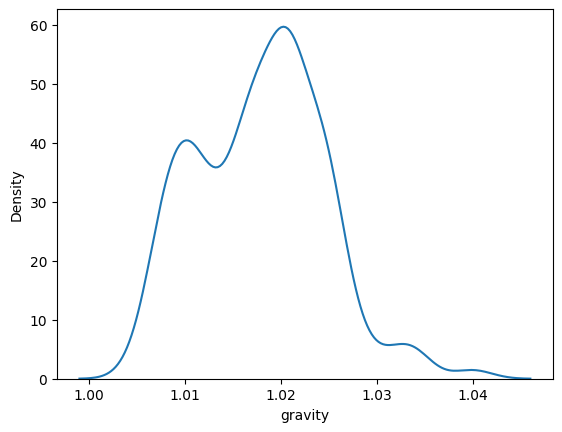

In [15]:
sns.kdeplot(df3["gravity"])

<Axes: xlabel='ph', ylabel='Density'>

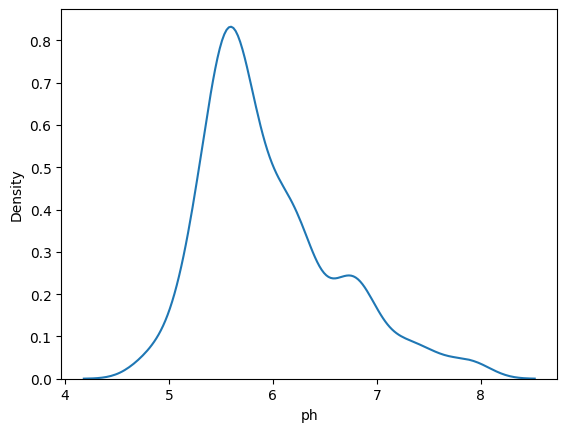

In [16]:
sns.kdeplot(df3["ph"])


<Axes: xlabel='osmo', ylabel='Density'>

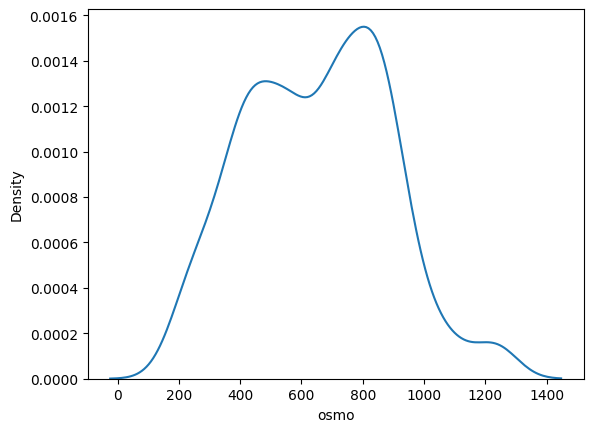

In [17]:
sns.kdeplot(df3["osmo"])


<Axes: xlabel='cond', ylabel='Density'>

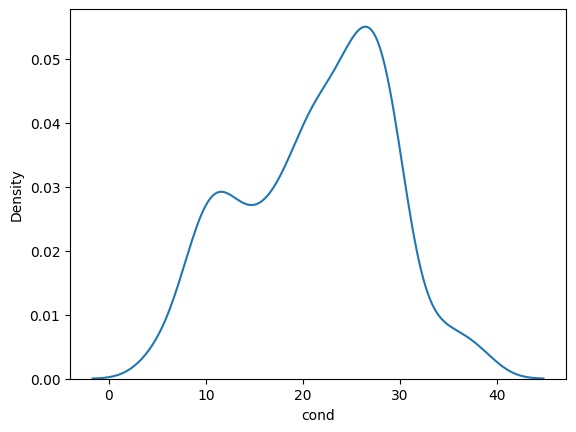

In [18]:
sns.kdeplot(df3["cond"])


<Axes: xlabel='urea', ylabel='Density'>

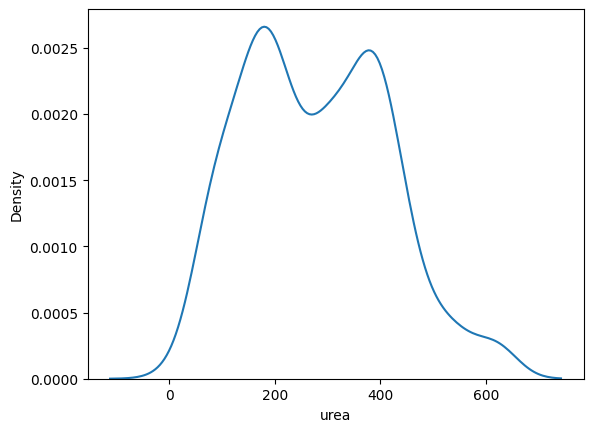

In [19]:
sns.kdeplot(df3["urea"])


<Axes: xlabel='calc', ylabel='Density'>

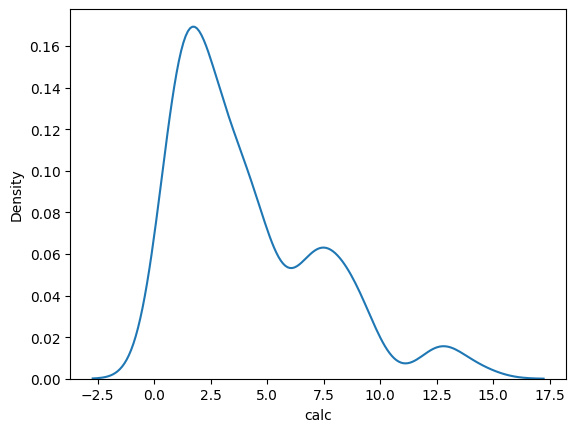

In [20]:
sns.kdeplot(df3["calc"])


## 5.2 Bivariate

In [21]:
df5[["calc","target"]].groupby("target").mean().reset_index()

,target,calc
0,0,2.771000
1,1,5.794185


## 5.3 Multivariate

<Axes: >

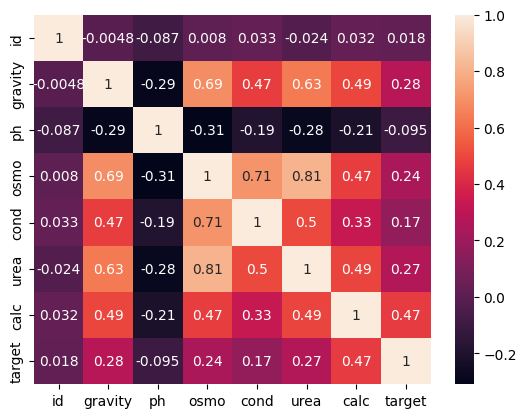

In [22]:
sns.heatmap(df5.corr(),annot=True)

# 6 - Transform Data

In [23]:
df6 = df5

## 6.1 Rescalling

In [24]:
scaler = StandardScaler()

scaler.fit(df6[num_attributes])

test = scaler.transform(df6[num_attributes])

df6[num_attributes] = test

df6

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,-0.734032,0.365623,-0.889728,-0.884388,-1.134869,-0.829136,0
1,1,1.065904,-0.865897,0.219521,0.288059,0.846384,0.020338,0
2,2,-1.334010,0.272090,-1.196904,0.407969,-0.878040,1.532589,0
3,3,0.465925,-1.629751,-0.893994,-0.084992,0.875736,0.782687,1
4,4,0.465925,-0.663242,0.949065,-0.484690,0.780342,-0.592652,1
...,...,...,...,...,...,...,...,...
409,409,-1.034021,-1.162085,-0.531355,-0.005053,-1.494430,-0.804243,0
410,410,0.915909,-0.663242,-0.318038,-0.231548,-0.401072,-1.040727,0
411,411,0.015941,0.505922,-0.838532,0.101534,-0.063525,1.109408,1
412,412,-1.484005,1.815386,-1.393156,-1.177500,-1.494430,-0.959824,1


In [25]:
#TODO: Test other transformations

# 7 - Model Data

In [26]:
df7 = df6

In [27]:
x = df7[num_attributes]
y = df7["target"]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [28]:
#TODO: Cross Validation

# 8 - Machine Learning

## 8.1 - Linear Regression

In [29]:
lr  = LinearRegression()

lr.fit(x_train,y_train)

lr_predict = lr.predict(x_test)

roc_auc_score(y_test,lr_predict)

0.7755581668625147


## 8.2 XGBoost

In [30]:
xgb_reg = xgb.XGBRegressor()

xgb_reg.fit(x_train,y_train)

xgb_predict = xgb_reg.predict(x_test)

roc_auc_score(y_test,xgb_predict)

0.6774383078730905

## 8.3 Random Forest

In [31]:
rf = RandomForestRegressor()


rf.fit(x_train,y_train)

rf_predict = rf.predict(x_test)

roc_auc_score(y_test,rf_predict)

0.7538190364277321

# 9 - Fine Tunning

In [35]:
random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [36]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   1.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   1.8s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   1.8s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   2.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [38]:
best_params = {'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

# 10 - Results

## 10.1 - Test Transformation

In [40]:
test = raw_test.drop(columns="id")

scaler = StandardScaler()

scaler.fit(test)

test = scaler.transform(test)

test

array([[-0.20280456, -1.15389851, -1.31346969, -1.41646667, -0.95805062,
        -0.94613039],
       [ 0.25474905, -0.42787688,  0.92868895,  0.97008721,  0.77257632,
        -0.20008534],
       [ 0.86482054, -0.95589261,  0.18271557, -0.32547061,  0.54232124,
         2.89437981],
       ...,
       [ 1.93244564, -0.42787688,  0.92868895,  0.97008721,  0.73543841,
         0.1340131 ],
       [ 0.10223118, -0.7743872 , -0.47424963, -0.06635904, -0.82435412,
        -0.79043403],
       [-0.20280456,  0.41364819,  0.18271557,  0.97008721, -0.21529227,
        -0.17737962]])

## 10.2 - Predict test dataset

In [43]:
final_rf = RandomForestRegressor( n_estimators= 200,
 min_samples_split= 10,
 min_samples_leaf= 2,
 max_features= "sqrt",
 max_depth= 80,
 bootstrap= True)

final_rf.fit(x_train,y_train)

predictions = final_rf.predict(test)

/home/rodolfo/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## 10.3 - Creating Submision CSV

In [50]:
test

array([[-0.20280456, -1.15389851, -1.31346969, -1.41646667, -0.95805062,
        -0.94613039],
       [ 0.25474905, -0.42787688,  0.92868895,  0.97008721,  0.77257632,
        -0.20008534],
       [ 0.86482054, -0.95589261,  0.18271557, -0.32547061,  0.54232124,
         2.89437981],
       ...,
       [ 1.93244564, -0.42787688,  0.92868895,  0.97008721,  0.73543841,
         0.1340131 ],
       [ 0.10223118, -0.7743872 , -0.47424963, -0.06635904, -0.82435412,
        -0.79043403],
       [-0.20280456,  0.41364819,  0.18271557,  0.97008721, -0.21529227,
        -0.17737962]])

In [54]:
submission = pd.DataFrame({"id" : raw_test["id"].values,"target" : predictions})

submission.to_csv("../submissions/first_submission.csv",index=False)